# Feature Matching

## Learning Objectives

By the end of this notebook, you will be able to:
- Match features between two images
- Use Brute-Force matcher for feature matching
- Use FLANN-based matcher for fast matching
- Apply Lowe's ratio test to filter good matches
- Find objects in scenes using homography
- Understand when to use different distance metrics
- Build practical object recognition systems

---

## Setup

Import required libraries:

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# Configure matplotlib
%matplotlib inline
plt.rcParams['figure.figsize'] = (14, 8)

print("Libraries imported successfully!")
print(f"OpenCV version: {cv.__version__}")

Libraries imported successfully!
OpenCV version: 4.12.0


---

## Part 1: Introduction to Feature Matching

### What is Feature Matching?

**Feature matching** is the process of finding corresponding features (keypoints) between two or more images of the same scene or object.

### Why Match Features?

Feature matching enables:
- **Object recognition** - Find specific objects in images
- **Image stitching** - Create panoramas from multiple photos
- **3D reconstruction** - Build 3D models from 2D images
- **Motion tracking** - Track object movement across frames
- **Image registration** - Align images taken at different times
- **Visual odometry** - Estimate camera movement

### Matching Process:

1. **Detect features** in both images (SIFT, ORB, etc.)
2. **Compute descriptors** for each feature
3. **Match descriptors** between images
4. **Filter matches** to keep only good ones
5. **Use matches** for alignment, recognition, etc.

### Create Test Images

Let's create two images with a common object to demonstrate matching:

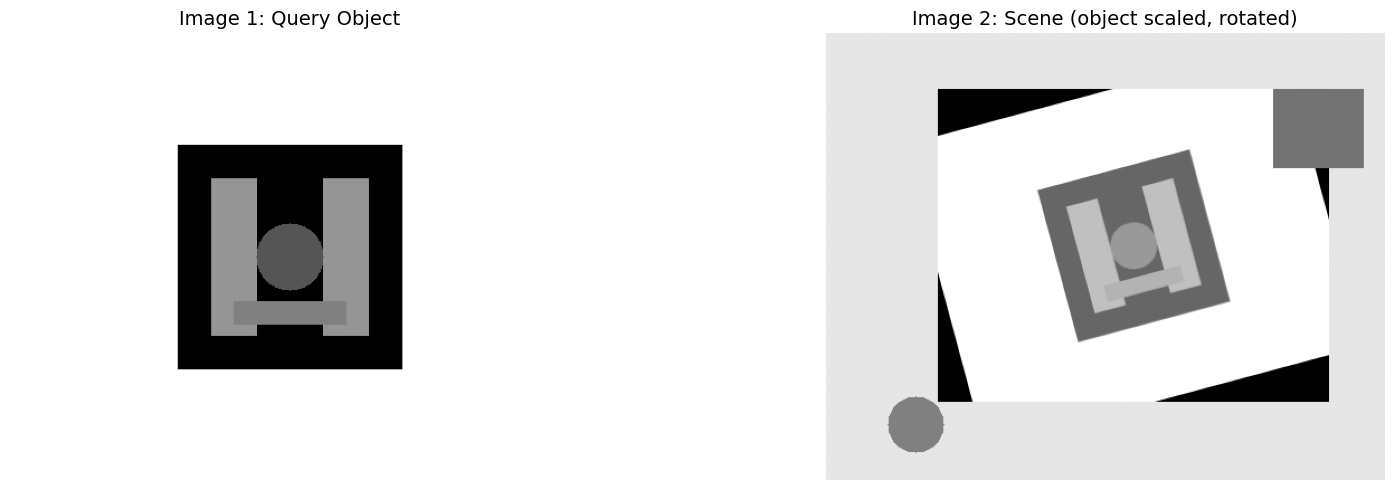

Goal: Find and match the object from Image 1 in Image 2


In [2]:
# Create image 1 with an object
img1 = np.ones((400, 500), dtype=np.uint8) * 200

# Add a distinctive pattern (our "object")
cv.rectangle(img1, (150, 100), (350, 300), 80, -1)
cv.rectangle(img1, (180, 130), (220, 270), 150, -1)
cv.rectangle(img1, (280, 130), (320, 270), 150, -1)
cv.circle(img1, (250, 200), 30, 120, -1)
cv.rectangle(img1, (200, 240), (300, 260), 140, -1)

# Create image 2 - same object but scaled and rotated
# First create the object
obj = np.ones((400, 500), dtype=np.uint8) * 200
cv.rectangle(obj, (150, 100), (350, 300), 80, -1)
cv.rectangle(obj, (180, 130), (220, 270), 150, -1)
cv.rectangle(obj, (280, 130), (320, 270), 150, -1)
cv.circle(obj, (250, 200), 30, 120, -1)
cv.rectangle(obj, (200, 240), (300, 260), 140, -1)

# Scale and rotate
scaled = cv.resize(obj, None, fx=0.7, fy=0.7)
center = (scaled.shape[1] // 2, scaled.shape[0] // 2)
rotation_matrix = cv.getRotationMatrix2D(center, 15, 1.0)
img2 = cv.warpAffine(scaled, rotation_matrix, (scaled.shape[1], scaled.shape[0]))

# Add it to a different scene
img2_scene = np.ones((400, 500), dtype=np.uint8) * 180
img2_scene[50:50+img2.shape[0], 100:100+img2.shape[1]] = img2

# Add some noise and other objects to scene
cv.circle(img2_scene, (80, 350), 25, 100, -1)
cv.rectangle(img2_scene, (400, 50), (480, 120), 90, -1)

# Display
plt.figure(figsize=(18, 5))

plt.subplot(1, 2, 1)
plt.imshow(img1, cmap='gray')
plt.title('Image 1: Query Object', fontsize=14)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img2_scene, cmap='gray')
plt.title('Image 2: Scene (object scaled, rotated)', fontsize=14)
plt.axis('off')

plt.tight_layout()
plt.show()

print("Goal: Find and match the object from Image 1 in Image 2")

---

## Part 2: Brute-Force Matcher

### What is Brute-Force Matching?

**Brute-Force (BF) matcher** compares each descriptor in the first set with all descriptors in the second set and returns the closest match.

### Distance Metrics:

- **NORM_L1**: Manhattan distance (sum of absolute differences)
- **NORM_L2**: Euclidean distance (used for SIFT, SURF)
- **NORM_HAMMING**: Hamming distance (used for ORB, BRIEF, BRISK)
- **NORM_HAMMING2**: For ORB when WTA_K == 3 or 4

### When to Use:
- **Small datasets** - Fast enough for < 1000 features
- **Accuracy critical** - Guarantees finding best match
- **Binary descriptors** - Very fast with Hamming distance

Image 1: 136 keypoints detected
Image 2: 231 keypoints detected

Found 71 matches
Best match distance: 1.0
Worst match distance: 56.0


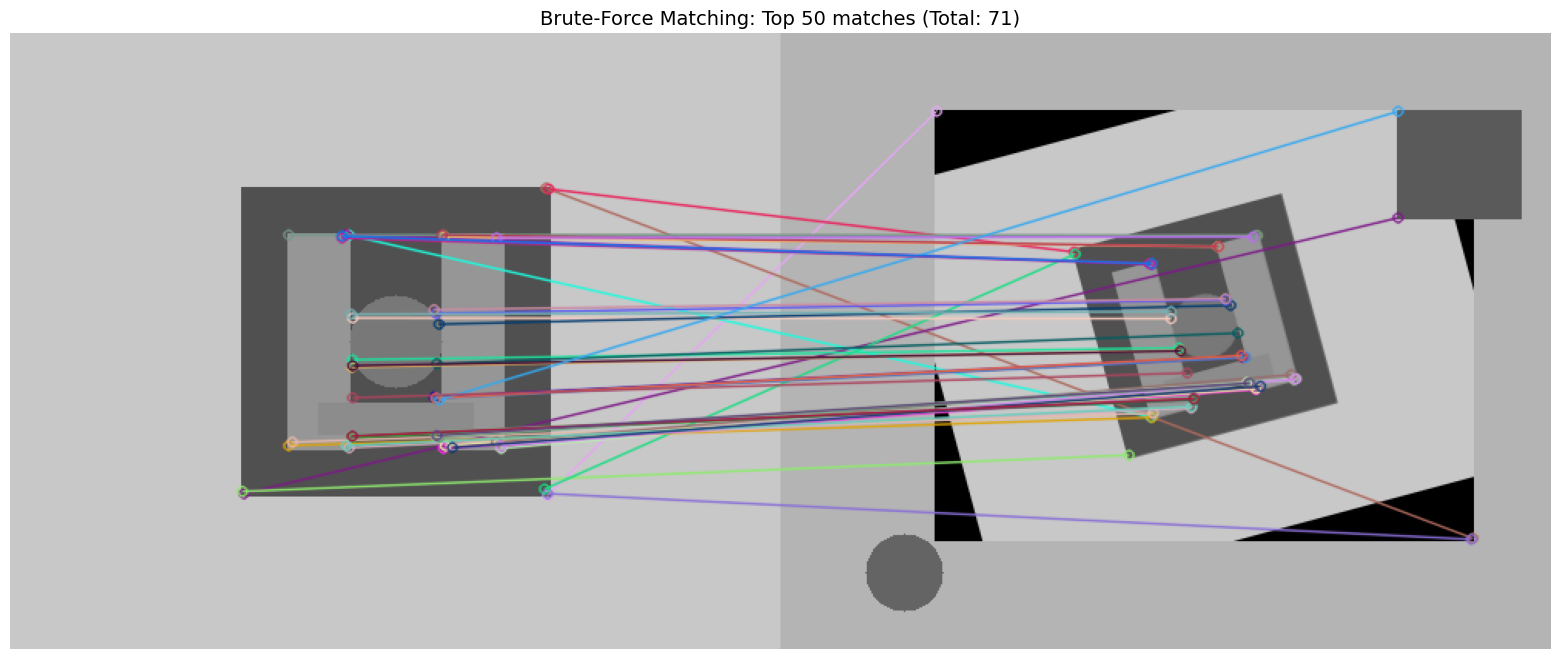

In [3]:
# Detect features using ORB
orb = cv.ORB_create(nfeatures=500)

# Find keypoints and descriptors
kp1, des1 = orb.detectAndCompute(img1, None)
kp2, des2 = orb.detectAndCompute(img2_scene, None)

print(f"Image 1: {len(kp1)} keypoints detected")
print(f"Image 2: {len(kp2)} keypoints detected")

# Create BF Matcher
# Use NORM_HAMMING for ORB (binary descriptors)
bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)

# Match descriptors
matches = bf.match(des1, des2)

# Sort matches by distance (best matches first)
matches = sorted(matches, key=lambda x: x.distance)

print(f"\nFound {len(matches)} matches")
print(f"Best match distance: {matches[0].distance}")
print(f"Worst match distance: {matches[-1].distance}")

# Draw top 50 matches
img_matches = cv.drawMatches(img1, kp1, img2_scene, kp2, matches[:50], None, 
                             flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(20, 8))
plt.imshow(img_matches)
plt.title(f'Brute-Force Matching: Top 50 matches (Total: {len(matches)})', fontsize=14)
plt.axis('off')
plt.show()

---

## Part 3: FLANN-based Matcher

### What is FLANN?

**FLANN** (Fast Library for Approximate Nearest Neighbors) is much faster than Brute-Force for large datasets.

### Trade-off:
- **Speed**: Much faster (especially for 1000+ features)
- **Accuracy**: Approximate (may miss perfect match)

### Index Types:

1. **KDTreeIndex** - For SIFT, SURF (float descriptors)
2. **LSHIndex** - For ORB, BRIEF (binary descriptors)
3. **AutotunedIndex** - Automatically choose best algorithm

In [4]:
import time

# Detect with SIFT (for FLANN example)
sift = cv.SIFT_create(nfeatures=500)
kp1_sift, des1_sift = sift.detectAndCompute(img1, None)
kp2_sift, des2_sift = sift.detectAndCompute(img2_scene, None)

# FLANN parameters for SIFT
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)  # Higher = more accurate, slower

# Create FLANN matcher
flann = cv.FlannBasedMatcher(index_params, search_params)

# Match
start = time.time()
matches_flann = flann.knnMatch(des1_sift, des2_sift, k=2)
flann_time = time.time() - start

# Compare with BF matcher
bf_sift = cv.BFMatcher(cv.NORM_L2)
start = time.time()
matches_bf = bf_sift.knnMatch(des1_sift, des2_sift, k=2)
bf_time = time.time() - start

print(f"FLANN matching time: {flann_time*1000:.2f}ms")
print(f"BF matching time: {bf_time*1000:.2f}ms")
print(f"FLANN is {bf_time/flann_time:.1f}x faster!")
print(f"\nFLANN found {len(matches_flann)} match pairs")
print(f"BF found {len(matches_bf)} match pairs")

FLANN matching time: 3.89ms
BF matching time: 0.23ms
FLANN is 0.1x faster!

FLANN found 32 match pairs
BF found 32 match pairs


---

## Part 4: Lowe's Ratio Test

### Problem: False Matches

Not all matches are good. Some are false positives caused by:
- Similar-looking features
- Repetitive patterns
- Noise

### Lowe's Ratio Test Solution:

For each feature, find the **2 best matches**:
- If the best match is **much better** than the second best, it's likely correct
- Ratio = distance1 / distance2
- Keep match if ratio < 0.7 (typical threshold)

### Why it Works:

- **Good match**: Best is much better than second (low ratio)
- **Bad match**: Best and second are similar (high ratio)

Total matches: 32
Good matches (ratio test): 16
Filtered out: 16 (50.0%)


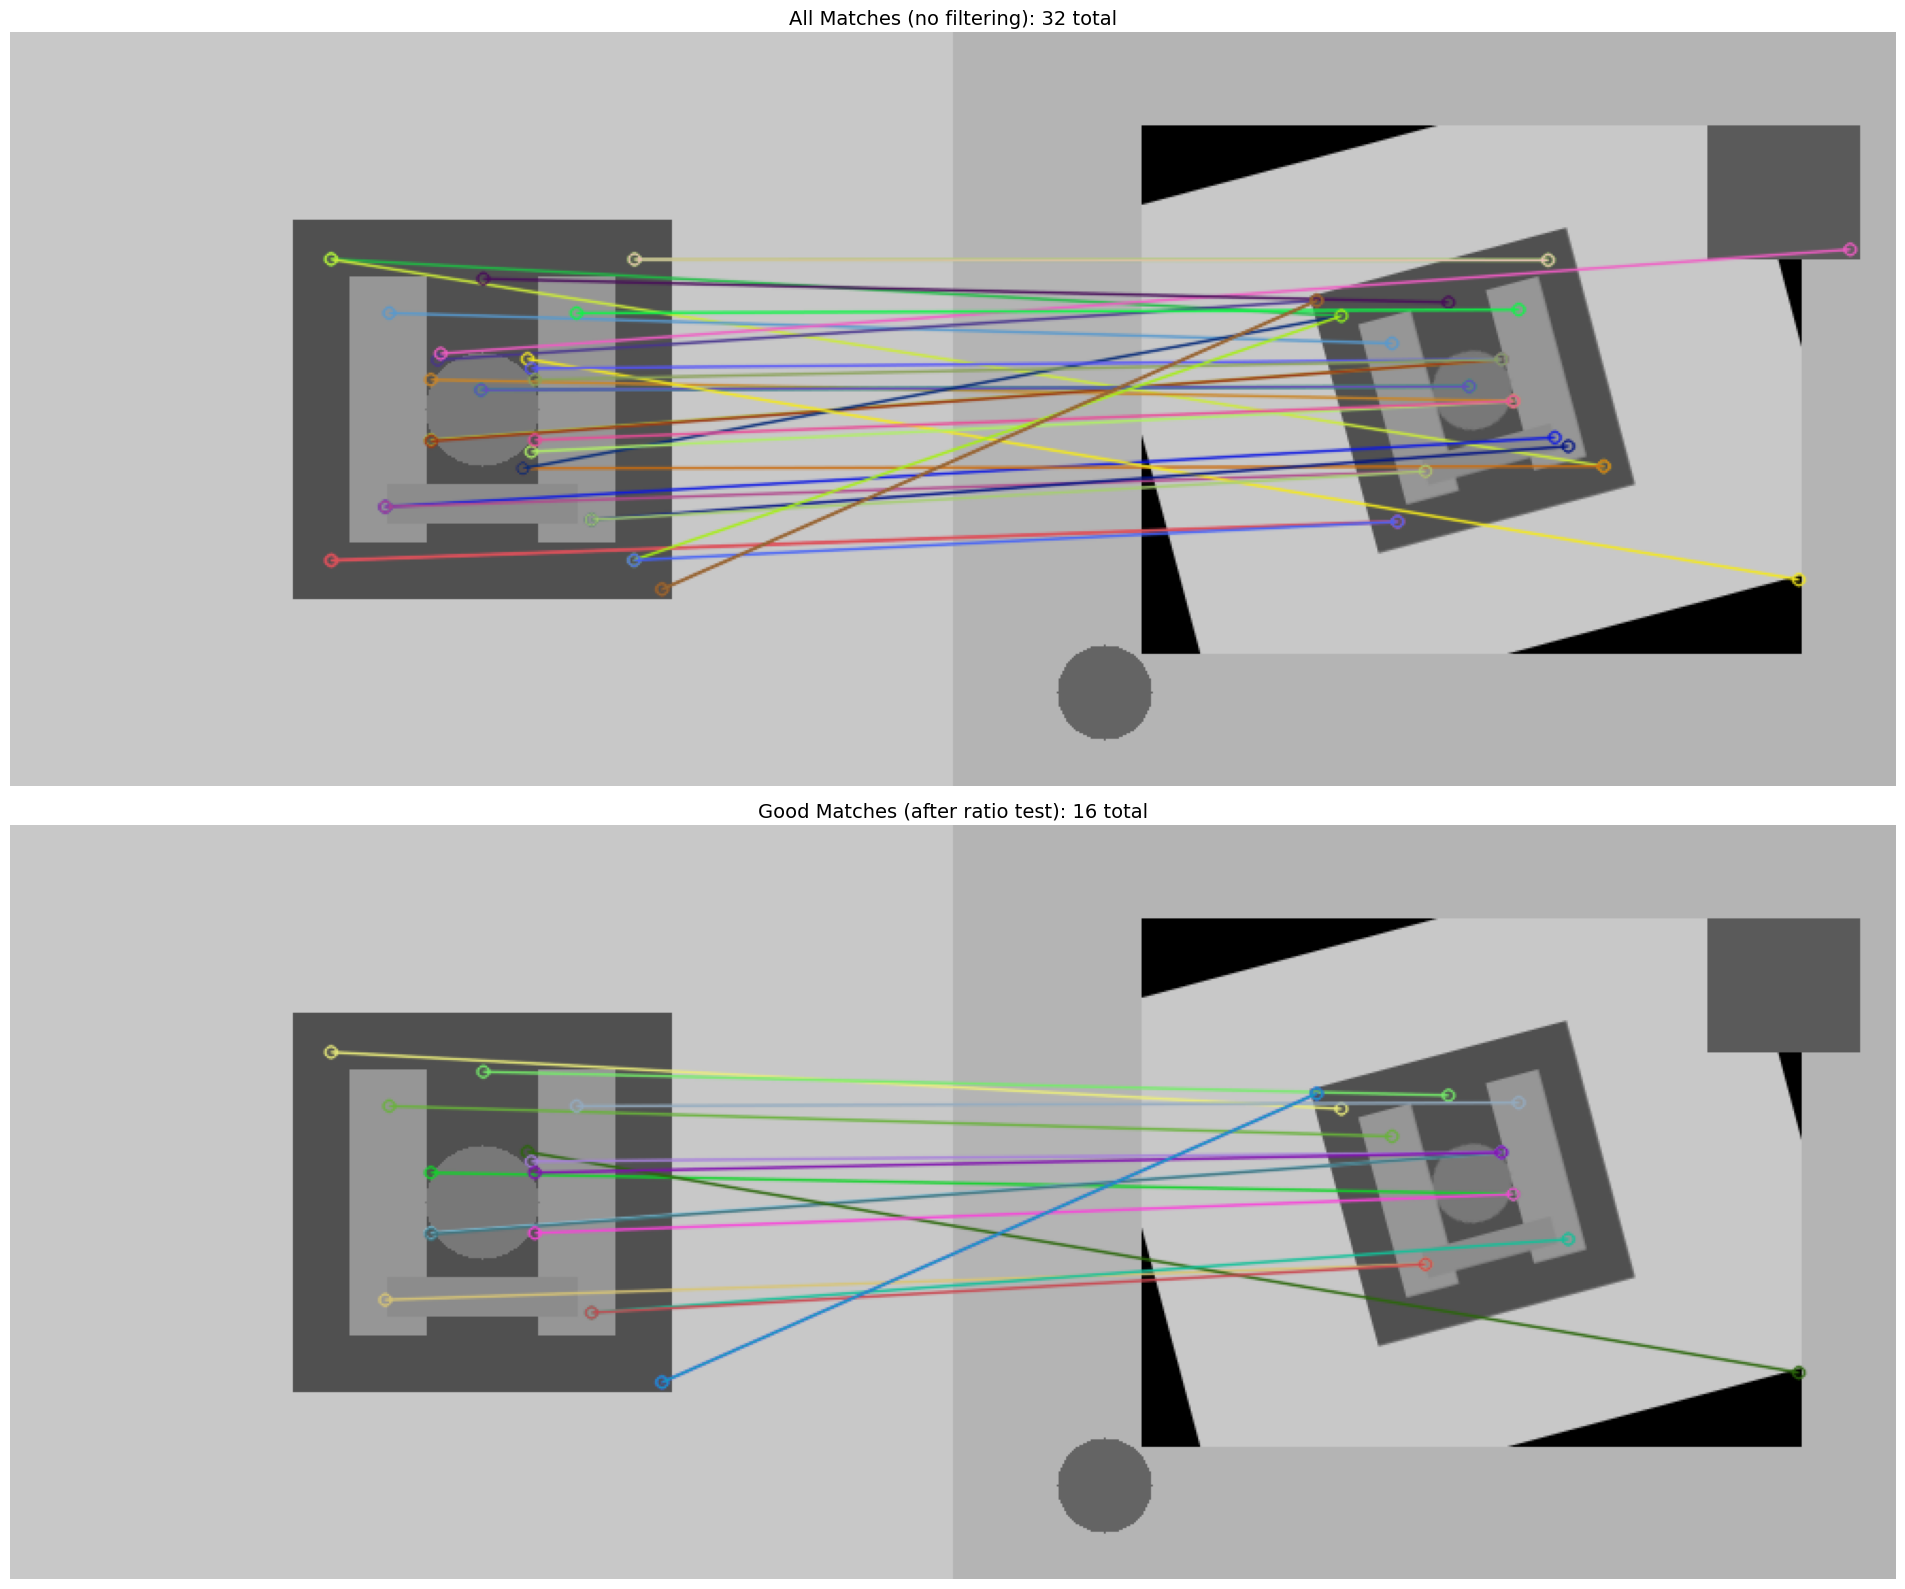


Ratio test effectively removes false matches!


In [5]:
# Apply Lowe's ratio test
good_matches = []
for m, n in matches_flann:
    if m.distance < 0.7 * n.distance:
        good_matches.append(m)

print(f"Total matches: {len(matches_flann)}")
print(f"Good matches (ratio test): {len(good_matches)}")
print(f"Filtered out: {len(matches_flann) - len(good_matches)} ({(1 - len(good_matches)/len(matches_flann))*100:.1f}%)")

# Draw matches
img_all_matches = cv.drawMatches(img1, kp1_sift, img2_scene, kp2_sift, 
                                 [m for m, n in matches_flann[:100]], None,
                                 flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

img_good_matches = cv.drawMatches(img1, kp1_sift, img2_scene, kp2_sift, 
                                  good_matches[:100], None,
                                  flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Display comparison
plt.figure(figsize=(20, 16))

plt.subplot(2, 1, 1)
plt.imshow(img_all_matches)
plt.title(f'All Matches (no filtering): {len(matches_flann)} total', fontsize=14)
plt.axis('off')

plt.subplot(2, 1, 2)
plt.imshow(img_good_matches)
plt.title(f'Good Matches (after ratio test): {len(good_matches)} total', fontsize=14)
plt.axis('off')

plt.tight_layout()
plt.show()

print("\nRatio test effectively removes false matches!")

### 💡 Parameter Tuning Tips for Feature Matching

**Lowe's Ratio Test**:
- `ratio_threshold` (0.5-0.9): Lower = stricter, fewer but better matches
  - 0.5-0.6: Very strict, best matches only
  - 0.7: Recommended by Lowe (good balance)
  - 0.8-0.9: More matches, but may include false positives

**FLANN Matcher Parameters**:
- `trees` (1-16): More trees = better accuracy but slower
- `checks` (10-100): More checks = better accuracy but slower
- Typical: trees=5, checks=50 for balanced performance

**RANSAC for Homography**:
- `ransacReprojThreshold` (1.0-10.0): Pixel threshold for inliers
  - 1.0-3.0: Strict, very accurate homography
  - 4.0-5.0: Balanced (recommended)
  - 6.0-10.0: Loose, more inliers but less accurate

**Minimum Matches**:
- At least 4 points needed for homography
- Recommended: 10-20 minimum for robust results
- More matches = more reliable homography

**When to adjust**:
- Too many false matches: Decrease ratio threshold
- Too few matches: Increase ratio threshold, decrease RANSAC threshold
- Homography fails: Increase minimum matches requirement

---

## Part 5: Finding Objects with Homography

### What is Homography?

A **homography** is a transformation matrix that maps points from one plane to another. It handles:
- Rotation
- Translation
- Scale
- Perspective distortion

### Using Homography for Object Detection:

1. Match features between query and scene
2. Find homography matrix from matches
3. Use homography to transform query corners to scene
4. Draw bounding box around detected object

### RANSAC:

**RANSAC** (RANdom SAmple Consensus) is used to find homography robustly:
- Handles outliers (false matches)
- Finds best transformation that fits most matches

Object detected!
Inliers: 9/16 (56.2%)
Homography matrix found:
[[ 6.49128196e-01  2.21559442e-01  6.79839516e+01]
 [-1.88633885e-01  6.87302453e-01  9.94848554e+01]
 [-1.06555052e-04  1.22440593e-04  1.00000000e+00]]


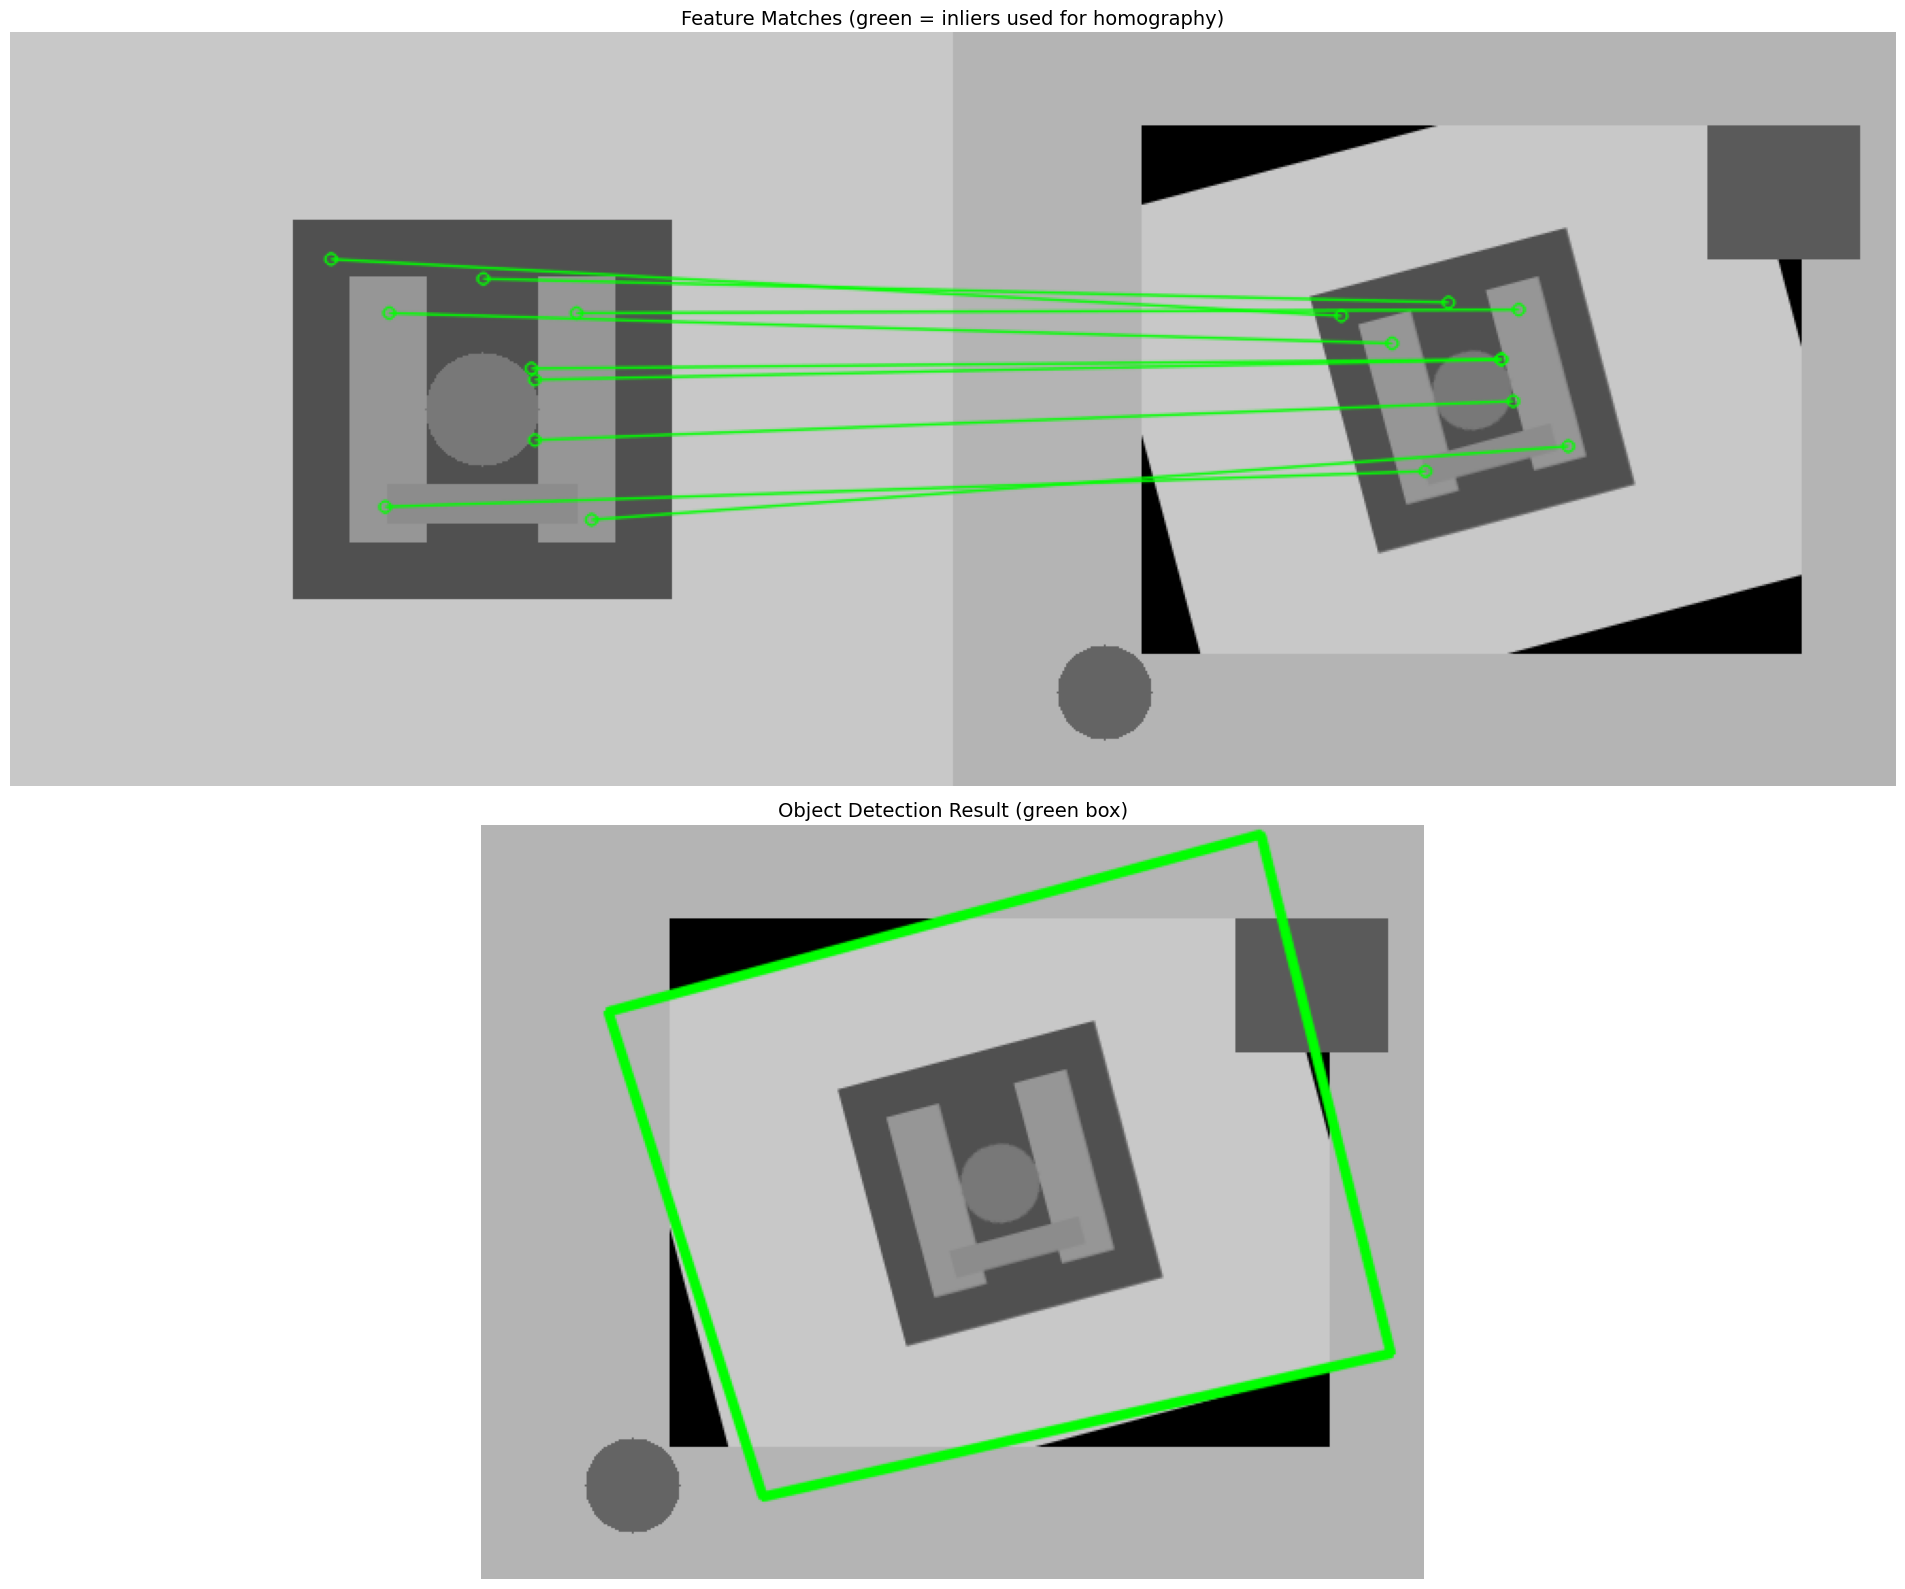

In [6]:
# Minimum number of matches required
MIN_MATCH_COUNT = 10

if len(good_matches) > MIN_MATCH_COUNT:
    # Extract location of good matches
    src_pts = np.float32([kp1_sift[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2_sift[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    
    # Find homography
    M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 5.0)
    matchesMask = mask.ravel().tolist()
    
    # Get dimensions of query image
    h, w = img1.shape
    
    # Define corners of query image
    pts = np.float32([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]]).reshape(-1, 1, 2)
    
    # Transform corners to scene
    dst = cv.perspectiveTransform(pts, M)
    
    # Draw bounding box in scene image
    img2_detected = cv.cvtColor(img2_scene, cv.COLOR_GRAY2BGR)
    img2_detected = cv.polylines(img2_detected, [np.int32(dst)], True, (0, 255, 0), 3, cv.LINE_AA)
    
    # Count inliers
    inliers = np.sum(matchesMask)
    
    print(f"Object detected!")
    print(f"Inliers: {inliers}/{len(good_matches)} ({inliers/len(good_matches)*100:.1f}%)")
    print(f"Homography matrix found:")
    print(M)
    
else:
    print(f"Not enough matches found - {len(good_matches)}/{MIN_MATCH_COUNT}")
    matchesMask = None
    img2_detected = cv.cvtColor(img2_scene, cv.COLOR_GRAY2BGR)

# Draw matches with inliers highlighted
draw_params = dict(matchColor=(0, 255, 0),  # Green for inliers
                   singlePointColor=None,
                   matchesMask=matchesMask,  # Only draw inliers
                   flags=2)

img_homography = cv.drawMatches(img1, kp1_sift, img2_scene, kp2_sift, 
                                good_matches, None, **draw_params)

# Display results
plt.figure(figsize=(20, 16))

plt.subplot(2, 1, 1)
plt.imshow(img_homography)
plt.title(f'Feature Matches (green = inliers used for homography)', fontsize=14)
plt.axis('off')

plt.subplot(2, 1, 2)
plt.imshow(cv.cvtColor(img2_detected, cv.COLOR_BGR2RGB))
plt.title('Object Detection Result (green box)', fontsize=14)
plt.axis('off')

plt.tight_layout()
plt.show()

---

## Part 6: Complete Object Recognition Pipeline

OBJECT RECOGNITION PIPELINE
Step 1: Feature Detection
  Query: 32 keypoints
  Scene: 52 keypoints

Step 2: Feature Matching
  Total matches: 32

Step 3: Ratio Test (threshold=0.7)
  Good matches: 16
  Filtered: 16

Step 4: Homography (RANSAC)
  Inliers: 9/16 (56.2%)

✓ Object FOUND!


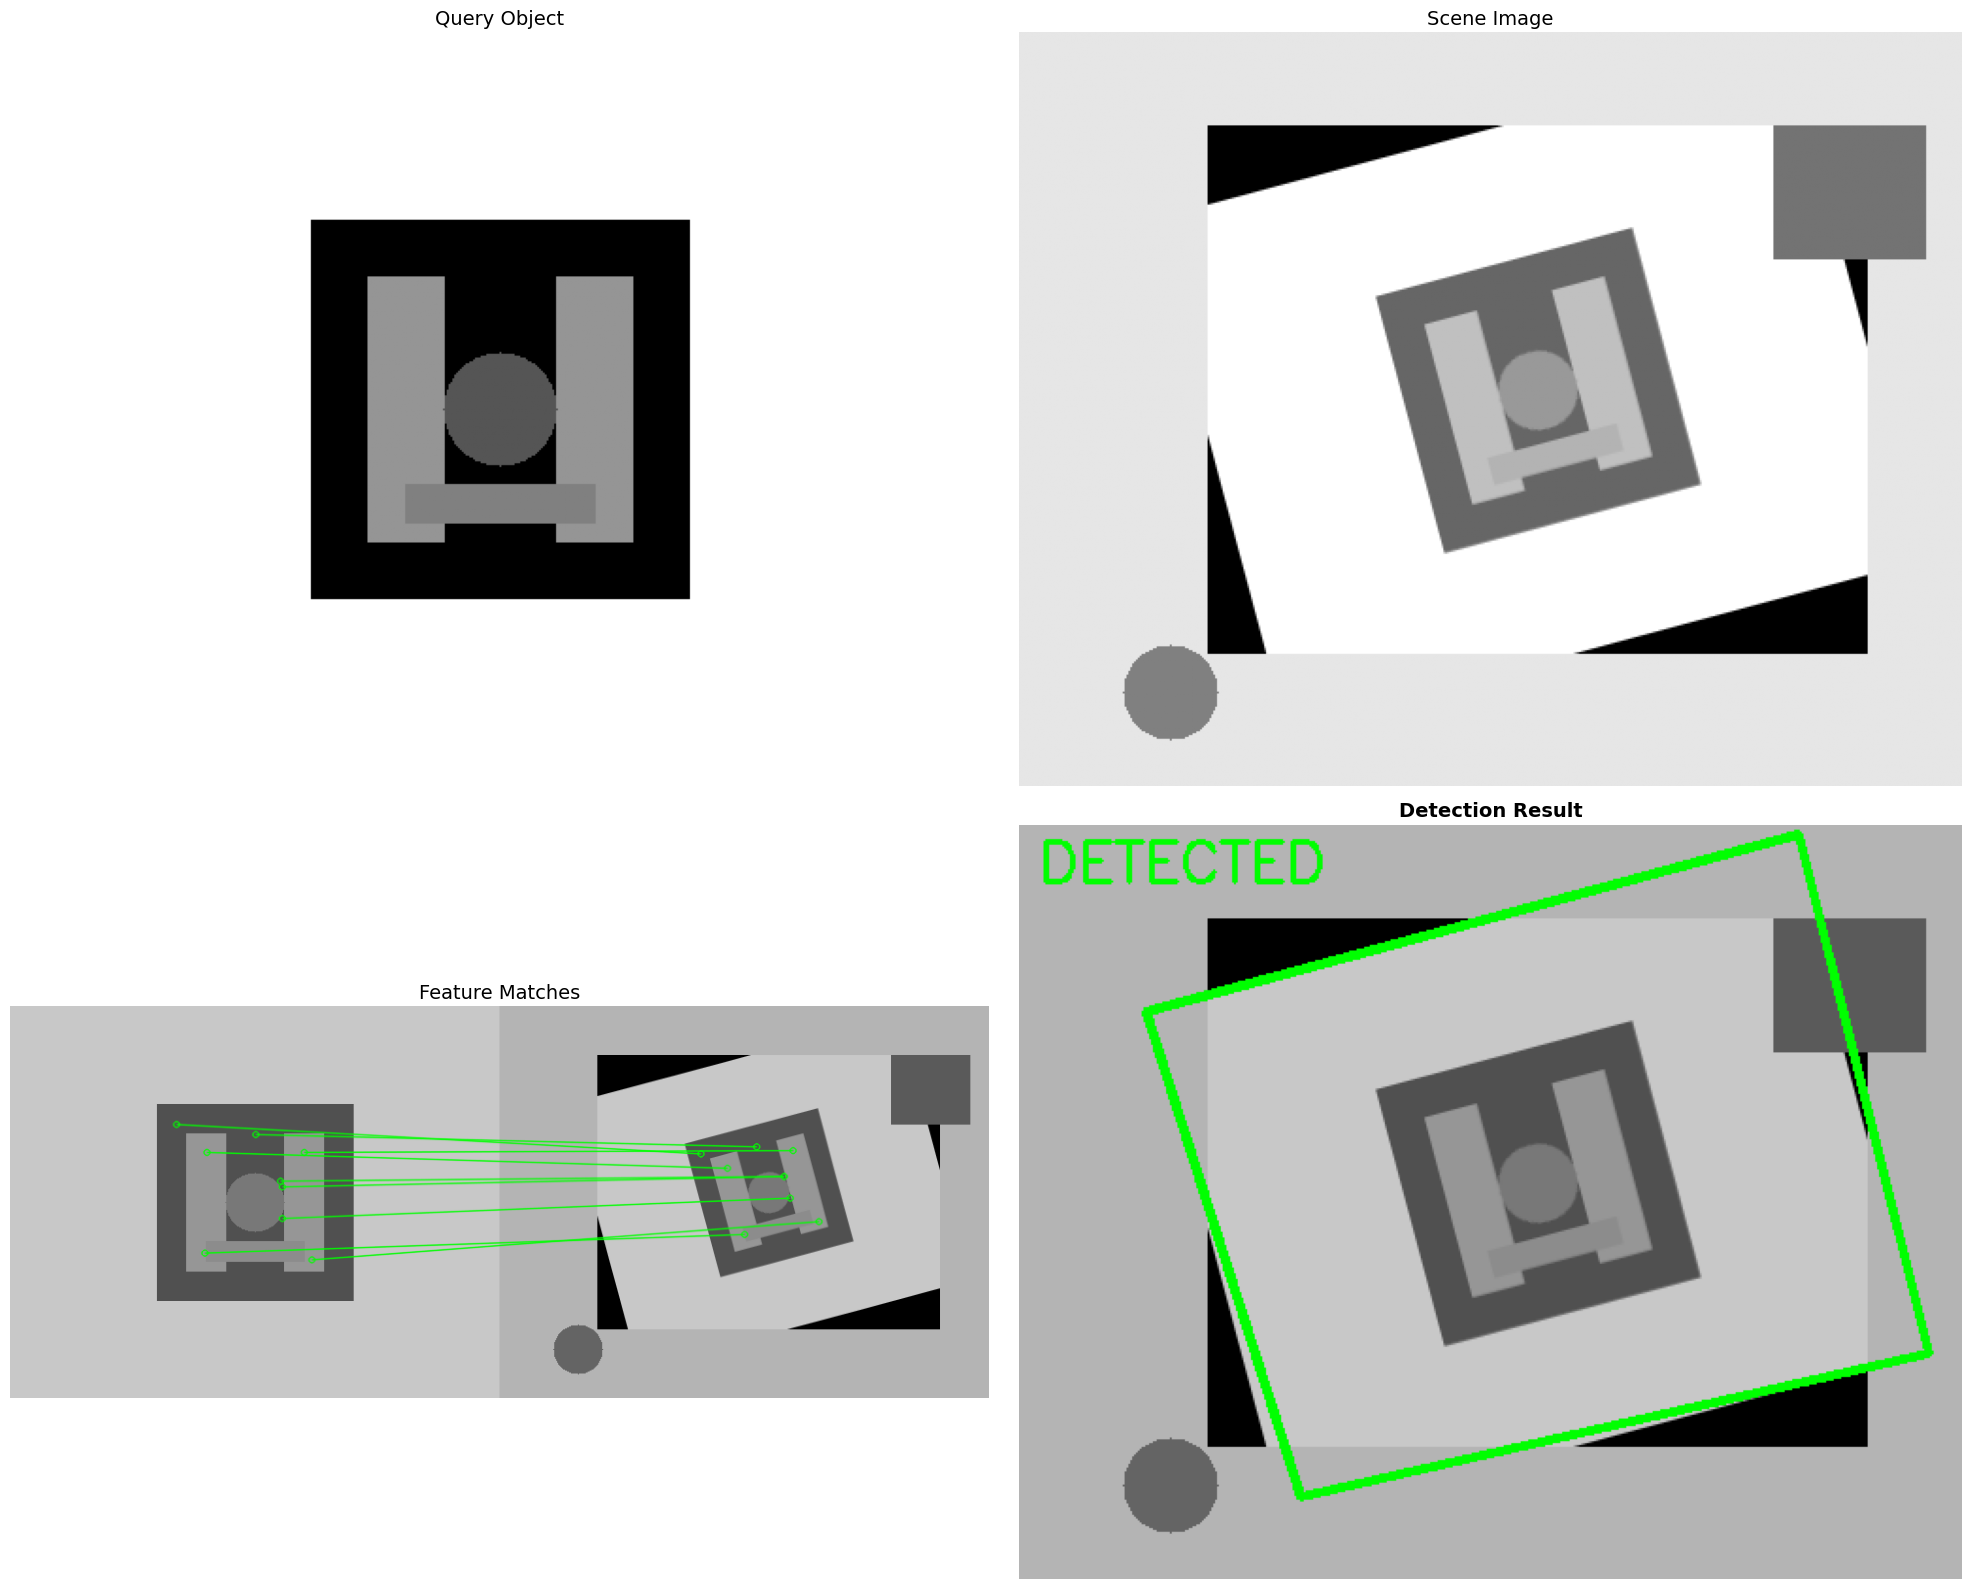

In [7]:
def find_object(query_img, scene_img, min_matches=10, ratio_thresh=0.7):
    """
    Complete pipeline to find query object in scene image.
    
    Args:
        query_img: Query/template image (grayscale)
        scene_img: Scene image to search in (grayscale)
        min_matches: Minimum number of good matches required
        ratio_thresh: Ratio test threshold (default 0.7)
        
    Returns:
        detected_img: Scene image with bounding box
        matches_img: Visualization of matches
        found: Boolean indicating if object was found
    """
    
    # Step 1: Detect features
    sift = cv.SIFT_create()
    kp1, des1 = sift.detectAndCompute(query_img, None)
    kp2, des2 = sift.detectAndCompute(scene_img, None)
    
    print(f"Step 1: Feature Detection")
    print(f"  Query: {len(kp1)} keypoints")
    print(f"  Scene: {len(kp2)} keypoints")
    
    # Step 2: Match features
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1, des2, k=2)
    
    print(f"\nStep 2: Feature Matching")
    print(f"  Total matches: {len(matches)}")
    
    # Step 3: Apply ratio test
    good_matches = []
    for m, n in matches:
        if m.distance < ratio_thresh * n.distance:
            good_matches.append(m)
    
    print(f"\nStep 3: Ratio Test (threshold={ratio_thresh})")
    print(f"  Good matches: {len(good_matches)}")
    print(f"  Filtered: {len(matches) - len(good_matches)}")
    
    # Step 4: Find homography
    if len(good_matches) > min_matches:
        src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        
        M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 5.0)
        matchesMask = mask.ravel().tolist()
        inliers = np.sum(matchesMask)
        
        print(f"\nStep 4: Homography (RANSAC)")
        print(f"  Inliers: {inliers}/{len(good_matches)} ({inliers/len(good_matches)*100:.1f}%)")
        
        # Transform corners
        h, w = query_img.shape
        pts = np.float32([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]]).reshape(-1, 1, 2)
        dst = cv.perspectiveTransform(pts, M)
        
        # Draw detection
        detected_img = cv.cvtColor(scene_img, cv.COLOR_GRAY2BGR)
        detected_img = cv.polylines(detected_img, [np.int32(dst)], True, (0, 255, 0), 3)
        cv.putText(detected_img, 'DETECTED', (10, 30), cv.FONT_HERSHEY_SIMPLEX, 
                  1, (0, 255, 0), 2)
        
        # Draw matches
        draw_params = dict(matchColor=(0, 255, 0),
                          singlePointColor=None,
                          matchesMask=matchesMask,
                          flags=2)
        matches_img = cv.drawMatches(query_img, kp1, scene_img, kp2, 
                                     good_matches, None, **draw_params)
        
        print(f"\n✓ Object FOUND!")
        return detected_img, matches_img, True
    
    else:
        print(f"\n✗ Object NOT FOUND")
        print(f"  Reason: Insufficient matches ({len(good_matches)}/{min_matches})")
        
        detected_img = cv.cvtColor(scene_img, cv.COLOR_GRAY2BGR)
        cv.putText(detected_img, 'NOT FOUND', (10, 30), cv.FONT_HERSHEY_SIMPLEX, 
                  1, (0, 0, 255), 2)
        
        matches_img = cv.drawMatches(query_img, kp1, scene_img, kp2, 
                                     good_matches, None,
                                     flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
        
        return detected_img, matches_img, False

# Test the pipeline
print("="*60)
print("OBJECT RECOGNITION PIPELINE")
print("="*60)

detected, matches_viz, found = find_object(img1, img2_scene)

# Display
plt.figure(figsize=(20, 16))

plt.subplot(2, 2, 1)
plt.imshow(img1, cmap='gray')
plt.title('Query Object', fontsize=14)
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(img2_scene, cmap='gray')
plt.title('Scene Image', fontsize=14)
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(matches_viz)
plt.title('Feature Matches', fontsize=14)
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(cv.cvtColor(detected, cv.COLOR_BGR2RGB))
plt.title('Detection Result', fontsize=14, fontweight='bold')
plt.axis('off')

plt.tight_layout()
plt.show()

---

## Part 7: Matcher Comparison

Testing SIFT + BF Matcher...
Testing SIFT + FLANN Matcher...
Testing ORB + BF Matcher...


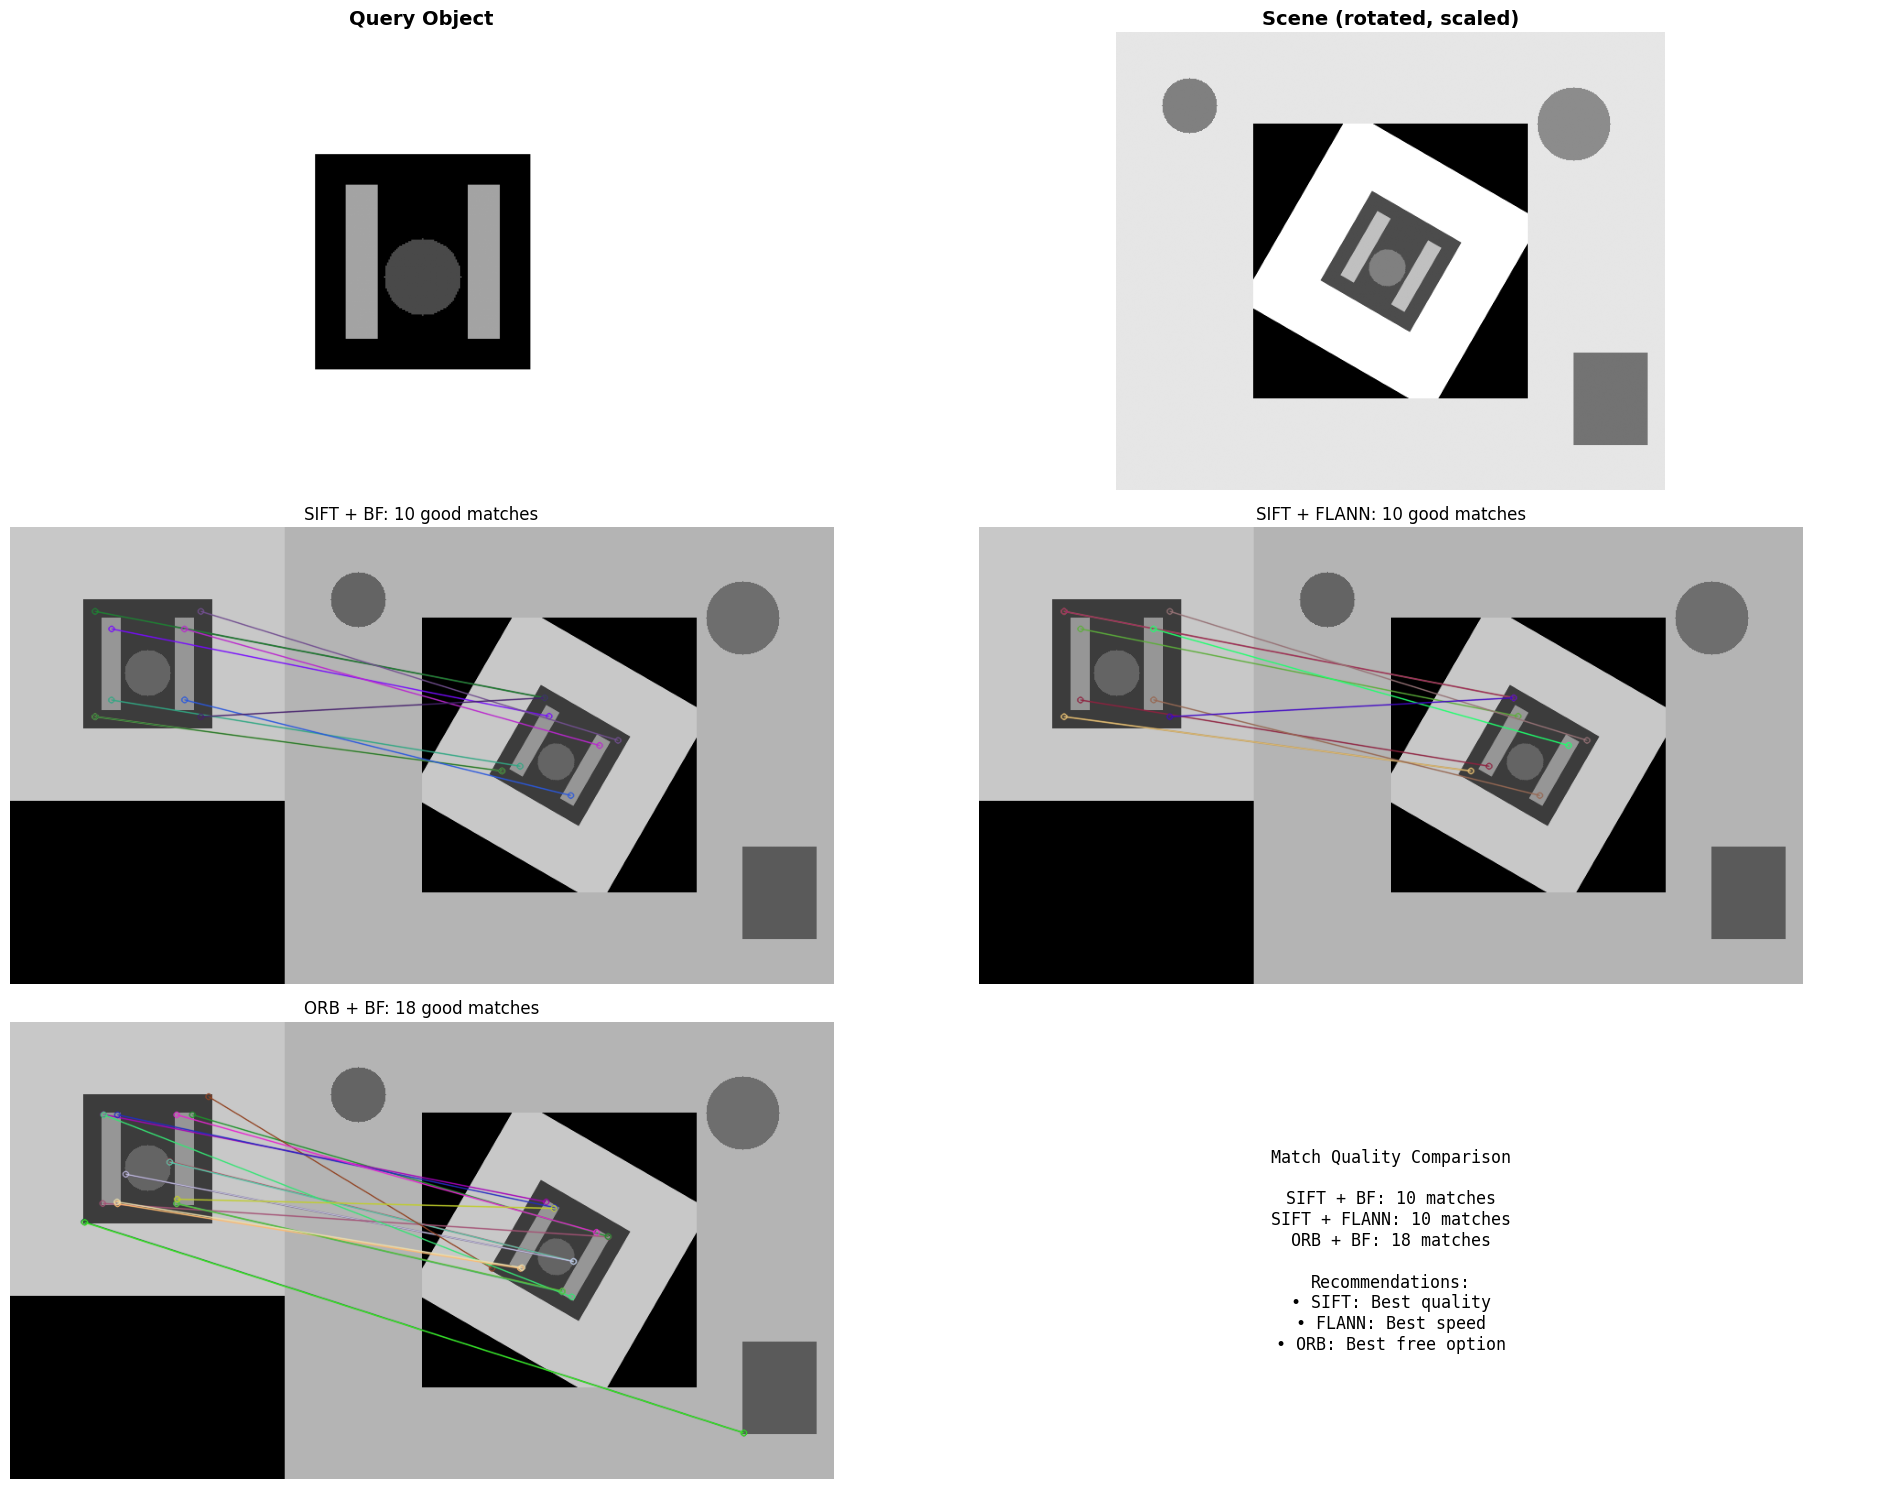


MATCHER COMPARISON RESULTS
SIFT + BF            10 good matches
SIFT + FLANN         10 good matches
ORB + BF             18 good matches


In [8]:
# Create more complex scene
complex_query = np.ones((300, 300), dtype=np.uint8) * 200
cv.rectangle(complex_query, (80, 80), (220, 220), 60, -1)
cv.rectangle(complex_query, (100, 100), (120, 200), 150, -1)
cv.rectangle(complex_query, (180, 100), (200, 200), 150, -1)
cv.circle(complex_query, (150, 160), 25, 100, -1)

complex_scene = np.ones((500, 600), dtype=np.uint8) * 180

# Add rotated query
M_rot = cv.getRotationMatrix2D((150, 150), -30, 0.8)
rotated = cv.warpAffine(complex_query, M_rot, (300, 300))
complex_scene[100:400, 150:450] = rotated

# Add clutter
cv.circle(complex_scene, (80, 80), 30, 100, -1)
cv.rectangle(complex_scene, (500, 350), (580, 450), 90, -1)
cv.circle(complex_scene, (500, 100), 40, 110, -1)

# Test with different detectors and matchers
results = {}

# 1. SIFT + BF
print("Testing SIFT + BF Matcher...")
sift = cv.SIFT_create()
kp_q, des_q = sift.detectAndCompute(complex_query, None)
kp_s, des_s = sift.detectAndCompute(complex_scene, None)
bf = cv.BFMatcher(cv.NORM_L2)
matches = bf.knnMatch(des_q, des_s, k=2)
good = [m for m, n in matches if m.distance < 0.7 * n.distance]
results['SIFT + BF'] = len(good)
img_sift_bf = cv.drawMatches(complex_query, kp_q, complex_scene, kp_s, 
                             good[:30], None, flags=2)

# 2. SIFT + FLANN
print("Testing SIFT + FLANN Matcher...")
flann = cv.FlannBasedMatcher(dict(algorithm=1, trees=5), dict(checks=50))
matches = flann.knnMatch(des_q, des_s, k=2)
good = [m for m, n in matches if m.distance < 0.7 * n.distance]
results['SIFT + FLANN'] = len(good)
img_sift_flann = cv.drawMatches(complex_query, kp_q, complex_scene, kp_s, 
                                good[:30], None, flags=2)

# 3. ORB + BF
print("Testing ORB + BF Matcher...")
orb = cv.ORB_create(nfeatures=500)
kp_q_orb, des_q_orb = orb.detectAndCompute(complex_query, None)
kp_s_orb, des_s_orb = orb.detectAndCompute(complex_scene, None)
bf_orb = cv.BFMatcher(cv.NORM_HAMMING)
matches = bf_orb.knnMatch(des_q_orb, des_s_orb, k=2)
good = [m for m, n in matches if m.distance < 0.7 * n.distance]
results['ORB + BF'] = len(good)
img_orb_bf = cv.drawMatches(complex_query, kp_q_orb, complex_scene, kp_s_orb, 
                            good[:30], None, flags=2)

# Display comparison
plt.figure(figsize=(20, 15))

plt.subplot(3, 2, 1)
plt.imshow(complex_query, cmap='gray')
plt.title('Query Object', fontsize=14, fontweight='bold')
plt.axis('off')

plt.subplot(3, 2, 2)
plt.imshow(complex_scene, cmap='gray')
plt.title('Scene (rotated, scaled)', fontsize=14, fontweight='bold')
plt.axis('off')

plt.subplot(3, 2, 3)
plt.imshow(img_sift_bf)
plt.title(f'SIFT + BF: {results["SIFT + BF"]} good matches', fontsize=12)
plt.axis('off')

plt.subplot(3, 2, 4)
plt.imshow(img_sift_flann)
plt.title(f'SIFT + FLANN: {results["SIFT + FLANN"]} good matches', fontsize=12)
plt.axis('off')

plt.subplot(3, 2, 5)
plt.imshow(img_orb_bf)
plt.title(f'ORB + BF: {results["ORB + BF"]} good matches', fontsize=12)
plt.axis('off')

# Summary
plt.subplot(3, 2, 6)
plt.text(0.5, 0.5, 
         f'Match Quality Comparison\n\n' +
         f'SIFT + BF: {results["SIFT + BF"]} matches\n' +
         f'SIFT + FLANN: {results["SIFT + FLANN"]} matches\n' +
         f'ORB + BF: {results["ORB + BF"]} matches\n\n' +
         f'Recommendations:\n' +
         f'• SIFT: Best quality\n' +
         f'• FLANN: Best speed\n' +
         f'• ORB: Best free option',
         ha='center', va='center', fontsize=12, family='monospace')
plt.axis('off')

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("MATCHER COMPARISON RESULTS")
print("="*60)
for method, count in results.items():
    print(f"{method:<20} {count} good matches")
print("="*60)

---

## Part 8: Practical Exercises

### Exercise 1: Tune Matching Parameters

In [9]:
# TODO: Experiment with ratio test threshold:
# - Try values: 0.5, 0.6, 0.7, 0.8, 0.9
# - How does it affect number of matches?
# - How does it affect match quality?
# - What's the best threshold for your use case?

print("Experiment with different ratio thresholds!")
print("Lower threshold = fewer but better matches")
print("Higher threshold = more matches but more false positives")

Experiment with different ratio thresholds!
Lower threshold = fewer but better matches
Higher threshold = more matches but more false positives


### Exercise 2: Build a Multi-Object Detector

In [10]:
# TODO: Create a scene with multiple objects
# Try to detect each object separately
# Draw bounding boxes with different colors
# Count how many of each object is in the scene

print("Build a system that can find multiple different objects!")

Build a system that can find multiple different objects!


### Exercise 3: Image Alignment

In [11]:
# TODO: Take two images of the same scene from different angles
# Use feature matching and homography to align them
# Warp one image to match the other's perspective
# This is the basis for panorama stitching!

print("Use feature matching for image alignment!")
print("Hint: Use cv.warpPerspective with the homography matrix")

Use feature matching for image alignment!
Hint: Use cv.warpPerspective with the homography matrix


---

## Summary

Congratulations! You've completed Feature Matching. You now know:

✓ Feature matching concepts and applications  
✓ Brute-Force matcher - accurate but slower  
✓ FLANN matcher - fast approximate matching  
✓ Distance metrics (L2, Hamming) for different descriptors  
✓ Lowe's ratio test for filtering false matches  
✓ Homography for object detection and localization  
✓ RANSAC for robust estimation  
✓ Complete object recognition pipeline  

### Key Takeaways

1. **Feature matching finds correspondences** between images
2. **BF matcher is accurate** - checks all possibilities
3. **FLANN is fast** - approximate but good enough
4. **Distance metric matters** - L2 for SIFT, Hamming for ORB
5. **Ratio test filters false matches** - ratio < 0.7 typical
6. **Homography finds object location** - transforms query to scene
7. **RANSAC handles outliers** - robust to false matches
8. **Need sufficient matches** - typically 10+ for homography

---

## Matching Strategy Guide

| Scenario | Detector | Matcher | Distance | Why |
|----------|----------|---------|----------|-----|
| **High accuracy** | SIFT | BF | NORM_L2 | Best quality |
| **Large dataset** | SIFT | FLANN | NORM_L2 | Fast matching |
| **Real-time** | ORB | BF | NORM_HAMMING | Fast everything |
| **Free/commercial** | ORB | FLANN | NORM_HAMMING | No patents |
| **Rotation invariant** | SIFT/ORB | Either | Appropriate | Handle rotation |
| **Scale invariant** | SIFT | Either | NORM_L2 | Handle scaling |

---

## What's Next?

In the next notebook (**09_hand_gesture_recognition.ipynb**), you'll learn:
- MediaPipe hand tracking
- Hand landmark detection
- Gesture recognition
- Building gesture-controlled applications

---

## Real-World Applications

- **Augmented Reality**: Overlay graphics on real objects
- **Panorama Stitching**: Combine multiple photos
- **3D Reconstruction**: Build 3D models from 2D photos
- **Visual SLAM**: Robot/drone navigation
- **Product Recognition**: Identify products from photos
- **Document Alignment**: Scan and align documents

---

**Happy Coding!** 🎯🔗